In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-quality-datasets/Train.csv
/kaggle/input/air-quality-datasets/Test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.experimental import enable_iterative_imputer  # Required for IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the training and test data
train_data = pd.read_csv('/kaggle/input/air-quality-datasets/Train.csv')
test_data = pd.read_csv('/kaggle/input/air-quality-datasets/Test.csv')

In [4]:
train_data.head(2)

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0150
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.02721,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.46239,0.00024,0.35915,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.2672


In [5]:
train_data.isnull().sum()

id                               0
site_id                          0
site_latitude                    0
site_longitude                   0
city                             0
                              ... 
cloud_sensor_azimuth_angle    3077
cloud_sensor_zenith_angle     3077
cloud_solar_azimuth_angle     3077
cloud_solar_zenith_angle      3077
pm2_5                            0
Length: 80, dtype: int64

In [6]:
test_data.head(2)

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,id_ihxgrbq8bw,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-06,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.92642,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.00004,0.000109,9582.745678,-0.258421,0.019749,829420.3125,-100.330299,26.92642,-86.879776,25.512329,0.000243,1.11224,0.000213,0.079645,25.512329,-86.879776,26.92642,-100.330299,-0.258422,829420.3125,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.88567,25.530511
1,id_dg6s4fhiwe,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-07,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408162,829340.7500,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


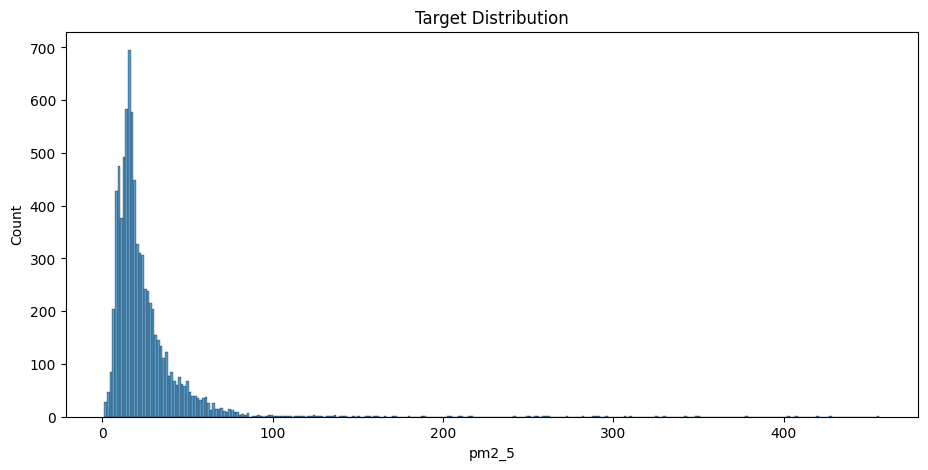

In [7]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train_data.pm2_5)
plt.title('Target Distribution')
plt.show()

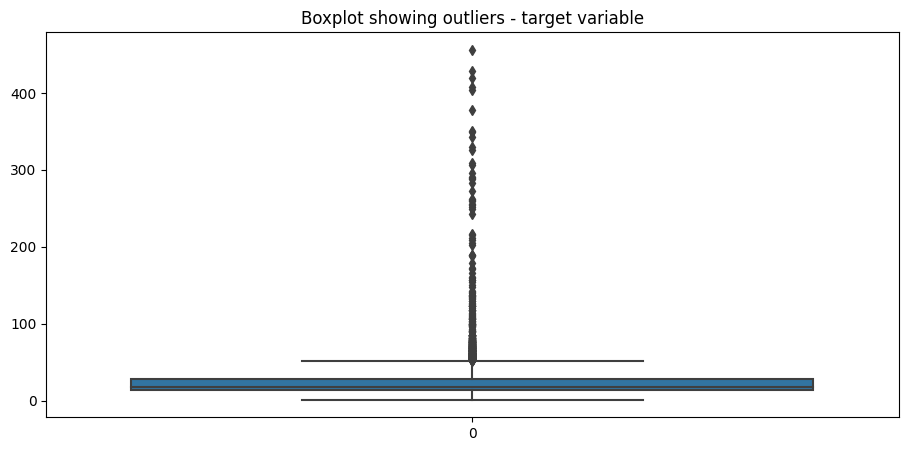

In [8]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train_data.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

In [9]:
train_relevant_features = []
for col in train_data.columns:
    if train_data[col].dtype != 'object' and col != 'id':
        train_relevant_features.append(col)

# Print the list of relevant features
print(train_relevant_features)

['site_latitude', 'site_longitude', 'hour', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_amf', 'sulphurdioxide_so2_slant_column_number_density', 'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle', 'sulphurdioxide_sensor_zenith_angle', 'sulphurdioxide_solar_azimuth_angle', 'sulphurdioxide_solar_zenith_angle', 'sulphurdioxide_so2_column_number_density_15km', 'month', 'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density', 'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude', 'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_sensor_zenith_angle', 'carbonmonoxide_solar_azimuth_angle', 'carbonmonoxide_solar_zenith_angle', 'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_stratospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'nitrogendioxide_tropopause_pressure', 'nitrogendioxid

In [10]:
test_relevant_features = []
for col in test_data.columns:
    if test_data[col].dtype != 'object' and col != 'id':
        test_relevant_features.append(col)

# Print the list of relevant features
print(test_relevant_features)

['site_latitude', 'site_longitude', 'hour', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_amf', 'sulphurdioxide_so2_slant_column_number_density', 'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle', 'sulphurdioxide_sensor_zenith_angle', 'sulphurdioxide_solar_azimuth_angle', 'sulphurdioxide_solar_zenith_angle', 'sulphurdioxide_so2_column_number_density_15km', 'month', 'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density', 'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude', 'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_sensor_zenith_angle', 'carbonmonoxide_solar_azimuth_angle', 'carbonmonoxide_solar_zenith_angle', 'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_stratospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'nitrogendioxide_tropopause_pressure', 'nitrogendioxid

In [11]:
# Assuming train_data is your DataFrame containing the actual data
train_relevant_features_df = train_data[train_relevant_features]

# Check the newly created DataFrame
train_relevant_features_df.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,6.53257,3.39936,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,6.53257,3.39936,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,6.53257,3.39936,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.756392,45185.49959,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
3,6.53257,3.39936,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [12]:
# Assuming train_data is your DataFrame containing the actual data
test_relevant_features_df = test_data[test_relevant_features]

# Check the newly created DataFrame
test_relevant_features_df.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,5.61252,-0.22955,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511
1,5.61252,-0.22955,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408162,829340.750000,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.61252,-0.22955,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9.0,0.037453,3046.314001,90.699029,829194.5625,71.272375,43.172868,-88.964294,16.440554,0.000062,0.000027,0.000036,0.000134,9582.743944,-0.115200,0.163328,829204.480816,73.117264,43.112466,-89.089083,16.417355,0.000145,1.345840,0.000127,

In [13]:
# Check if 'pm2_5' is missing in the test data and add a placeholder column if needed
if 'pm2_5' not in test_relevant_features_df.columns:
    test_relevant_features_df.loc[:, 'pm2_5'] = 0  # Add a placeholder column 'pm2_5' with value 0

# Initialize the IterativeImputer
imputer = IterativeImputer(random_state=42)

# Fit the imputer on the train and test data, and transform it
train_relevant_features_df_imputed = pd.DataFrame(imputer.fit_transform(train_relevant_features_df), columns=train_relevant_features_df.columns)
test_relevant_features_df_imputed = pd.DataFrame(imputer.transform(test_relevant_features_df), columns=test_relevant_features_df.columns)

In [14]:
# Check the imputed train DataFrame
train_relevant_features_df_imputed.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,6.53257,3.39936,13.0,-0.014086,10.463100,-0.004628,-30.064193,-95.584365,41.087198,-126.458700,44.410286,0.000573,10.0,0.063359,3471.410493,2901.608826,828933.701177,-91.922264,54.837439,-97.812697,29.475747,-0.014495,-0.012107,0.000164,-0.008917,-42046.775927,8.946408,-113.861518,829123.237294,-102.868437,41.116598,-112.959920,30.276456,0.003859,21.750056,0.001919,-15.290429,41.451798,-128.879334,38.678787,-97.275183,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,-1041.582421,108918.547285,-118.588062,85.606268,-61.315809,-144.009487,32.113792,1.216832,51615.172862,6054.859489,57507.835836,5165.447916,-121.327371,0.070486,-101.012505,23.025401,-123.208928,33.409082,12.015000
1,6.53257,3.39936,12.0,0.009501,1.281890,0.005873,0.396908,70.874932,59.208871,-143.488985,26.523821,0.002288,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,0.012249,0.010564,0.000001,0.007915,126723.755287,9.471610,99.916595,828558.660689,72.329552,47.528920,-148.205853,30.100856,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,5062.575660,49731.189662,-51.220857,204.522418,77.762765,-148.850572,63.262351,-0.975123,51100.868694,5886.542264,55011.122123,5404.571062,-547.5142

In [15]:
# Check the imputed test DataFrame
test_relevant_features_df_imputed.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,5.61252,-0.22955,13.0,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.937500,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,2226.423383,79257.579497,2.747250,27.676909,-100.258449,-87.061522,25.590013,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511,0.0
1,5.61252,-0.22955,13.0,0.008098,-11.304770,0.001828,21.510088,72.297870,-3.972458,-85.106381,12.596352,-0.000931,9.0,0.036341,2604.788330,1584.809692,829328.625000,70.753090,11.428769,-87.764297,20.935318,0.015616,0.013044,0.000022,0.010358,132568.063626,9.149753,118.383853,829387.273081,78.646304,-6.537203,-94.154387,26.244581,-0.003915,-17.992721,-0.002737,10.257945,14.903482,-83.292969,-2.323384,73.615437,-0.408162,829340.750000,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,5374.144425,46011.178335,30.152166,134.375590,78.502207,-94.827774,59.056312,-0.559605,51609.410043,6013.693573,57574.308834,5208.741335,-423.297620,0.650946,76.667188,11.0

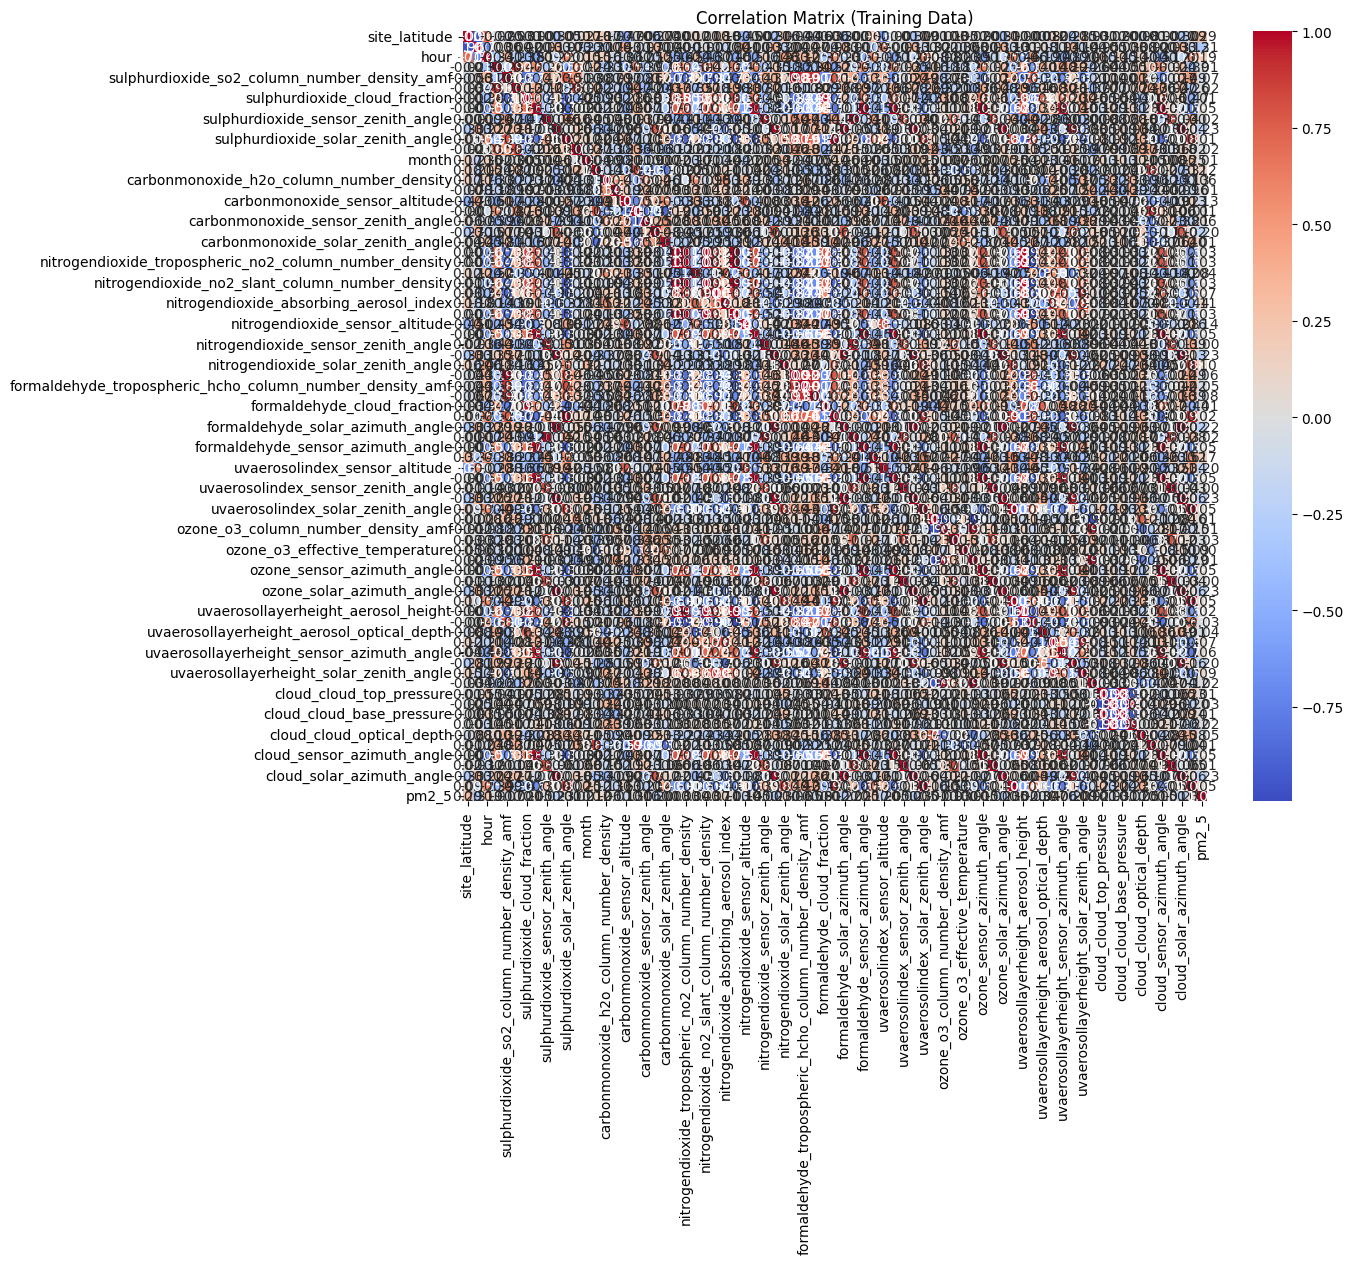

In [16]:
# Using the train_relevant_features_df_imputed DataFrame
# And also using the test_relevant_features_df_imputed DataFrame

# Calculate correlation matrix for training data
correlation_matrix_train = train_relevant_features_df_imputed.corr()

# Plotting the correlation matrix using heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Training Data)')
plt.show()

In [17]:
# Extract the correlation values of all features with the target variable 'pm2_5'
correlation_with_target = correlation_matrix_train['pm2_5']

# Compute the absolute values of these correlations
absolute_correlation_with_target = correlation_with_target.abs()

# Sort the absolute correlation values in descending order
sorted_absolute_correlation_with_target = absolute_correlation_with_target.sort_values(ascending=False)

# Display the sorted absolute correlation values
print(sorted_absolute_correlation_with_target)

pm2_5                                  1.000000
site_longitude                         0.305682
site_latitude                          0.288082
nitrogendioxide_solar_azimuth_angle    0.232872
cloud_solar_azimuth_angle              0.227888
                                         ...   
cloud_cloud_base_pressure              0.005916
nitrogendioxide_sensor_zenith_angle    0.004832
uvaerosolindex_sensor_zenith_angle     0.001694
ozone_sensor_zenith_angle              0.001014
ozone_o3_effective_temperature         0.000680
Name: pm2_5, Length: 75, dtype: float64


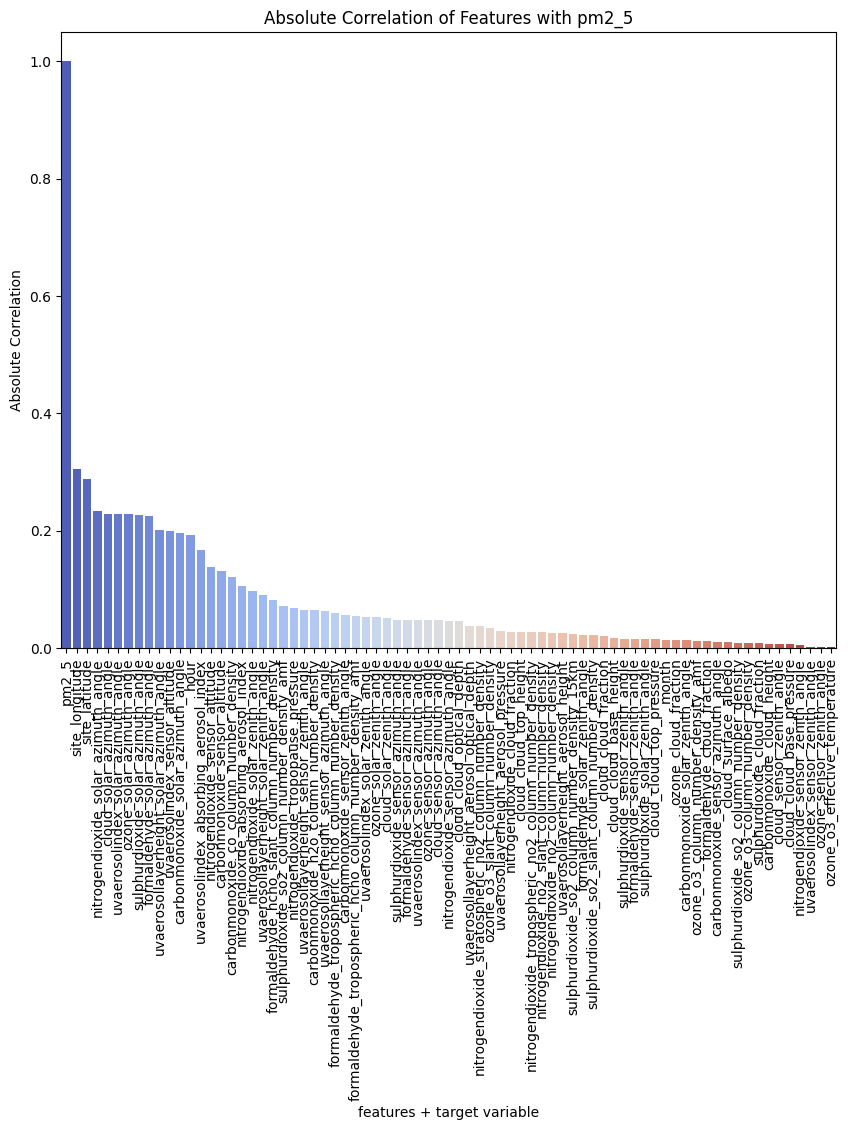

In [18]:
# Plotting the sorted absolute correlation values

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_absolute_correlation_with_target.index, y=sorted_absolute_correlation_with_target.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Absolute Correlation of Features with pm2_5')
plt.ylabel('Absolute Correlation')
plt.xlabel('features + target variable')
plt.show()

In [19]:
# Calculate VIF for training data
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(len(dataframe.columns))]
    return vif_data

train_vif_data = calculate_vif(train_relevant_features_df_imputed)
print(train_vif_data)

# Calculate VIF for test data (if needed)
test_vif_data = calculate_vif(test_relevant_features_df_imputed)
print(test_vif_data)

                                         Feature           VIF
0                                  site_latitude  2.626575e+03
1                                 site_longitude  1.394627e+04
2                                           hour  2.889006e+05
3       sulphurdioxide_so2_column_number_density  5.382769e+04
4   sulphurdioxide_so2_column_number_density_amf  3.031137e+05
..                                           ...           ...
70                    cloud_sensor_azimuth_angle  2.388470e+09
71                     cloud_sensor_zenith_angle  2.430085e+07
72                     cloud_solar_azimuth_angle  2.074834e+08
73                      cloud_solar_zenith_angle  1.248573e+08
74                                         pm2_5  4.652288e+01

[75 rows x 2 columns]
                                         Feature           VIF
0                                  site_latitude  7.929284e+03
1                                 site_longitude  4.043438e+04
2                               

In [20]:
# Filter features based on correlation with the target variable 'pm2_5'

target_correlation_threshold = 0.0008  # Set a threshold for correlation with the target variable
target_correlation = correlation_matrix_train['pm2_5'].abs()  # Get absolute correlation values
relevant_features_target = target_correlation[target_correlation > target_correlation_threshold].index.tolist()

relevant_features_target

['site_latitude',
 'site_longitude',
 'hour',
 'sulphurdioxide_so2_column_number_density',
 'sulphurdioxide_so2_column_number_density_amf',
 'sulphurdioxide_so2_slant_column_number_density',
 'sulphurdioxide_cloud_fraction',
 'sulphurdioxide_sensor_azimuth_angle',
 'sulphurdioxide_sensor_zenith_angle',
 'sulphurdioxide_solar_azimuth_angle',
 'sulphurdioxide_solar_zenith_angle',
 'sulphurdioxide_so2_column_number_density_15km',
 'month',
 'carbonmonoxide_co_column_number_density',
 'carbonmonoxide_h2o_column_number_density',
 'carbonmonoxide_cloud_height',
 'carbonmonoxide_sensor_altitude',
 'carbonmonoxide_sensor_azimuth_angle',
 'carbonmonoxide_sensor_zenith_angle',
 'carbonmonoxide_solar_azimuth_angle',
 'carbonmonoxide_solar_zenith_angle',
 'nitrogendioxide_no2_column_number_density',
 'nitrogendioxide_tropospheric_no2_column_number_density',
 'nitrogendioxide_stratospheric_no2_column_number_density',
 'nitrogendioxide_no2_slant_column_number_density',
 'nitrogendioxide_tropopause_p

In [21]:
# Filter features based on VIF values to remove multicollinear features

vif_threshold = 1000000000  # Set a threshold for VIF
relevant_features_vif = train_vif_data[train_vif_data['VIF'] < vif_threshold]['Feature'].tolist()

relevant_features_vif

['site_latitude',
 'site_longitude',
 'hour',
 'sulphurdioxide_so2_column_number_density',
 'sulphurdioxide_so2_column_number_density_amf',
 'sulphurdioxide_so2_slant_column_number_density',
 'sulphurdioxide_cloud_fraction',
 'sulphurdioxide_sensor_zenith_angle',
 'sulphurdioxide_solar_azimuth_angle',
 'sulphurdioxide_solar_zenith_angle',
 'sulphurdioxide_so2_column_number_density_15km',
 'month',
 'carbonmonoxide_co_column_number_density',
 'carbonmonoxide_h2o_column_number_density',
 'carbonmonoxide_cloud_height',
 'carbonmonoxide_sensor_azimuth_angle',
 'carbonmonoxide_sensor_zenith_angle',
 'carbonmonoxide_solar_azimuth_angle',
 'carbonmonoxide_solar_zenith_angle',
 'nitrogendioxide_no2_column_number_density',
 'nitrogendioxide_tropospheric_no2_column_number_density',
 'nitrogendioxide_stratospheric_no2_column_number_density',
 'nitrogendioxide_no2_slant_column_number_density',
 'nitrogendioxide_tropopause_pressure',
 'nitrogendioxide_absorbing_aerosol_index',
 'nitrogendioxide_clo

In [22]:
# Take the intersection of relevant features based on correlation and VIF
final_features = list(set(relevant_features_target).intersection(relevant_features_vif))

final_features

['formaldehyde_hcho_slant_column_number_density',
 'ozone_o3_column_number_density',
 'sulphurdioxide_solar_zenith_angle',
 'site_latitude',
 'carbonmonoxide_co_column_number_density',
 'sulphurdioxide_so2_column_number_density',
 'uvaerosolindex_absorbing_aerosol_index',
 'nitrogendioxide_no2_column_number_density',
 'cloud_solar_azimuth_angle',
 'carbonmonoxide_cloud_height',
 'ozone_sensor_zenith_angle',
 'site_longitude',
 'sulphurdioxide_so2_column_number_density_15km',
 'formaldehyde_tropospheric_hcho_column_number_density',
 'month',
 'cloud_cloud_base_height',
 'carbonmonoxide_solar_azimuth_angle',
 'nitrogendioxide_tropopause_pressure',
 'uvaerosollayerheight_aerosol_height',
 'sulphurdioxide_sensor_zenith_angle',
 'sulphurdioxide_so2_slant_column_number_density',
 'ozone_o3_column_number_density_amf',
 'formaldehyde_solar_zenith_angle',
 'ozone_o3_slant_column_number_density',
 'cloud_cloud_base_pressure',
 'nitrogendioxide_stratospheric_no2_column_number_density',
 'nitrogen

In [23]:
X_train_data = train_relevant_features_df_imputed[final_features]
X_train_data.head()

,formaldehyde_hcho_slant_column_number_density,ozone_o3_column_number_density,sulphurdioxide_solar_zenith_angle,site_latitude,carbonmonoxide_co_column_number_density,sulphurdioxide_so2_column_number_density,uvaerosolindex_absorbing_aerosol_index,nitrogendioxide_no2_column_number_density,cloud_solar_azimuth_angle,carbonmonoxide_cloud_height,ozone_sensor_zenith_angle,site_longitude,sulphurdioxide_so2_column_number_density_15km,formaldehyde_tropospheric_hcho_column_number_density,month,cloud_cloud_base_height,carbonmonoxide_solar_azimuth_angle,nitrogendioxide_tropopause_pressure,uvaerosollayerheight_aerosol_height,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_so2_slant_column_number_density,ozone_o3_column_number_density_amf,formaldehyde_solar_zenith_angle,ozone_o3_slant_column_number_density,cloud_cloud_base_pressure,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_absorbing_aerosol_index,cloud_cloud_top_pressure,cloud_cloud_fraction,nitrogendioxide_cloud_fraction,cloud_cloud_top_height,ozone_cloud_fraction,cloud_cloud_optical_depth,nitrogendioxide_tropospheric_no2_column_number_density,cloud_surface_albedo,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_solar_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_sensor_azimuth_angle,uvaerosollayerheight_aerosol_pressure,carbonmonoxide_h2o_column_number_density,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_aerosol_optical_depth,cloud_sensor_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density_amf,uvaerosollayerheight_sensor_zenith_angle,formaldehyde_sensor_zenith_angle,formaldehyde_cloud_fraction,formaldehyde_solar_azimuth_angle,sulphurdioxide_cloud_fraction,nitrogendioxide_no2_slant_column_number_density,uvaerosollayerheight_solar_zenith_angle,hour,cloud_solar_zenith_angle,pm2_5,carbonmonoxide_solar_zenith_angle
0,0.001919,0.122055,44.410286,6.53257,0.063359,-0.014086,0.052301,-0.014495,-123.208928,2901.608826,21.720518,3.39936,0.000573,0.003859,10.0,5165.447916,-97.812697,-42046.775927,-1041.582421,41.087198,-0.004628,2.301404,41.451798,0.285803,57507.835836,0.000164,8.946408,51615.172862,1.216832,-113.861518,6054.859489,0.906039,-121.327371,-0.012107,0.070486,10.463100,-126.458700,54.837439,-91.922264,108918.547285,3471.410493,-144.009487,-118.588062,23.025401,21.750056,85.606268,38.678787,-15.290429,-128.879334,-30.064193,-0.008917,32.113792,13.0,33.409082,12.015000,29.475747
1,0.000240,0.116975,26.523821,6.53257,0.045475,0.009501,-0.315206,0.012249,-143.465623,3399.756845,59.220097,3.39936,0.002288,0.000214,11.0,5404.571062,-143.370575,126723.755287,5062.575660,59.208871,0.005873,3.049902,26.525513,0.362203,55011.122123,0.000001,9.471610,51100.868694,-0.975123,99.916595,5886.542264,0.364713,-547.514204,0.010564,0.795393,1.281890,-143.488985,59.159695,69.245351,49731.189662,3771.027210,-148.850572,-51.220857,61.114778,1.462390,204.522418,59.220097,0.359150,-143.480164,0.396908,0.007915,63.262351,12.0,26.636110,42.267200,26.566997
2,0.002510,0.117559,51.976058,6.53257,0.062625,-0.016929,1.097816,-0.016345,-121.307414,3041.467075,61.045010,3.39936,-0.000477,0.004254,11.0,5791.682829,-92.096972,-113397.027668,-997.775400,79.307468,-0.006630,3.248703,49.183971,0.384168,51171.802486,0.000006,-9.408403,45185.499590,0.756392,-118.267150,6791.682888,0.754163,11.816715,-0.013385,0.192757,11.709618,-124.246647,79.575978,-56.345174,112072.911346,2319.164361,-106.611075,-48.880822,61.045123,21.636592,-90.697480,77.164004,-13.139301,-126.473577,-26.933494,-0.010948,-2.793697,13.0,41.898269,39.450741,33.573672
3,0.002576,0.118412,53.934285,6.53257,0.051771,-0.017780,0.591543,-0.016900,-121.470364,1975.318591,65.508858,3.39936,-0.000723,0.004271,11.0,5072.812868,-91.152563,-127589.160801,-943.189789,83.651711,-0.007182,3.505708,51.162479,0.416643,58316.639501,-0.000026,-13.633937,51641.318261,2.486584,-119.912133,6120.598073,1.000000,418.241372,-0.013772,-0.789528,12.012904,-125.158397,82.127039,-58.405204,113010

In [24]:
X_test_data = test_relevant_features_df_imputed[final_features]
X_test_data.head()

,formaldehyde_hcho_slant_column_number_density,ozone_o3_column_number_density,sulphurdioxide_solar_zenith_angle,site_latitude,carbonmonoxide_co_column_number_density,sulphurdioxide_so2_column_number_density,uvaerosolindex_absorbing_aerosol_index,nitrogendioxide_no2_column_number_density,cloud_solar_azimuth_angle,carbonmonoxide_cloud_height,ozone_sensor_zenith_angle,site_longitude,sulphurdioxide_so2_column_number_density_15km,formaldehyde_tropospheric_hcho_column_number_density,month,cloud_cloud_base_height,carbonmonoxide_solar_azimuth_angle,nitrogendioxide_tropopause_pressure,uvaerosollayerheight_aerosol_height,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_so2_slant_column_number_density,ozone_o3_column_number_density_amf,formaldehyde_solar_zenith_angle,ozone_o3_slant_column_number_density,cloud_cloud_base_pressure,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_absorbing_aerosol_index,cloud_cloud_top_pressure,cloud_cloud_fraction,nitrogendioxide_cloud_fraction,cloud_cloud_top_height,ozone_cloud_fraction,cloud_cloud_optical_depth,nitrogendioxide_tropospheric_no2_column_number_density,cloud_surface_albedo,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_solar_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_sensor_azimuth_angle,uvaerosollayerheight_aerosol_pressure,carbonmonoxide_h2o_column_number_density,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_aerosol_optical_depth,cloud_sensor_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density_amf,uvaerosollayerheight_sensor_zenith_angle,formaldehyde_sensor_zenith_angle,formaldehyde_cloud_fraction,formaldehyde_solar_azimuth_angle,sulphurdioxide_cloud_fraction,nitrogendioxide_no2_slant_column_number_density,uvaerosollayerheight_solar_zenith_angle,hour,cloud_solar_zenith_angle,pm2_5,carbonmonoxide_solar_zenith_angle
0,0.000213,0.126056,25.512329,5.61252,0.043537,-0.000072,-0.258422,0.000055,-86.885670,1.000000,26.926420,-0.22955,-0.000028,0.000243,9.0,1710.544483,-86.884308,9582.745678,2226.423383,26.926420,-0.000055,2.243713,25.512329,0.286278,83569.504246,0.000040,-0.258421,74217.403083,0.043065,0.019749,2710.544562,0.079324,3.063105,0.000016,0.263193,0.762543,-86.879776,26.897718,-97.787621,79257.579497,2825.323242,-87.061522,2.747250,27.059646,1.112240,27.676909,26.926420,0.079645,-86.879776,0.079645,0.000109,25.590013,13.0,25.530511,0.0,25.509418
1,-0.002737,0.126282,12.596352,5.61252,0.036341,0.008098,-0.408162,0.015616,-88.099492,1584.809692,11.171532,-0.22955,-0.000931,-0.003915,9.0,5208.741335,-87.764297,132568.063626,5374.144425,-3.972458,0.001828,2.136400,14.903482,0.273757,57574.308834,0.000022,9.149753,51609.410043,-0.559605,118.383853,6013.693573,0.613266,-423.297620,0.013044,0.650946,-11.304770,-85.106381,11.428769,70.753090,46011.178335,2604.788330,-94.827774,30.152166,11.041739,-17.992721,134.375590,-2.323384,10.257945,-83.292969,21.510088,0.010358,59.056312,13.0,21.448021,0.0,20.935318
2,0.000127,0.126162,16.417355,5.61252,0.037453,-0.000051,-0.115169,0.000062,-89.630687,90.699029,43.112466,-0.22955,-0.000023,0.000145,9.0,5269.014908,-88.964294,9582.743944,2183.681477,43.112466,-0.000051,2.428528,16.417355,0.311882,57034.447017,0.000036,-0.115200,51582.827537,-1.605115,0.163328,5971.528426,0.164370,-552.791943,0.000027,0.999737,1.004265,-89.089083,43.172868,71.272375,79013.667384,3046.314001,-89.417801,1.323855,42.907241,1.345840,44.967903,43.112466,0.163160,-89.089083,0.163160,0.000134,16.726064,13.0,17.168751,0.0,16.440554
3,-0.002685,0.121339,4.031797,5.61252,0.058814,0.009731,-1.116044,0.017178,-90.875603,3269.223807,61.874397,-0.22955,-0.000317,-0.003741,9.0,5585.034668,-101.129451,158099.016455,5371.347091,47.707889,0.003042,3.074277,6.193201,0.378890,52160.980469,0.000126,17.263477,46052.449219,0.845911,119.322478,6585.034668,0.845910,29.145922,0.013914,0.314945,-10.972690,-88.346770,86.548636,-21.549648,44506.400388,4626.143191,-120.649122,-11.420644,61.874222,-16.893359,318.3337

In [25]:
# Reshape y_train before outlier handling and transformation
y_train = train_data['pm2_5']
y_train_reshaped = y_train.values.reshape(-1, 1)

In [26]:
# Handle outliers using the IQR method
Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
y_train_clipped = np.where(y_train < lower_bound, lower_bound, y_train)
y_train_clipped = np.where(y_train > upper_bound, upper_bound, y_train)

In [27]:
# Reshape y_train_clipped before applying PowerTransformer
y_train_clipped_reshaped = y_train_clipped.reshape(-1, 1)

# Apply PowerTransformer to the target variable
transformer = PowerTransformer(method='yeo-johnson', standardize=True)
y_train_transformed = transformer.fit_transform(y_train_clipped_reshaped).flatten()

In [28]:
column = ['pm2_5']

y_train_transformed_df = pd.DataFrame(y_train_transformed, columns=column)
y_train_transformed_df

,pm2_5
0,-0.812670
1,1.404313
2,1.274659
3,-1.024053
4,-0.004050
...,...
8066,0.138381
8067,-0.223057
8068,-0.436953
8069,-0.133643


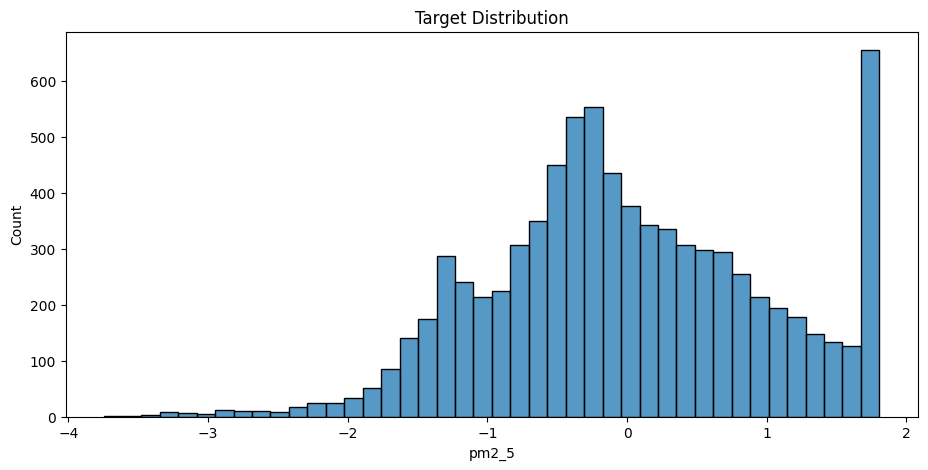

In [29]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(y_train_transformed_df.pm2_5)
plt.title('Target Distribution')
plt.show()

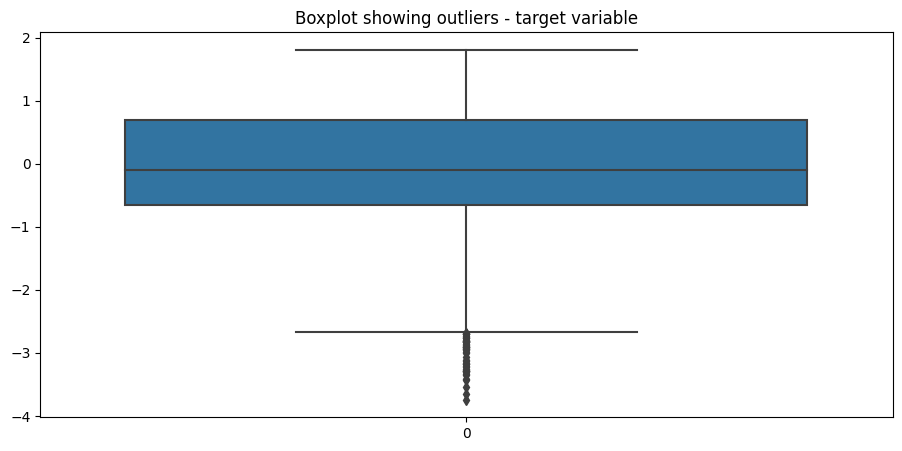

In [30]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(y_train_transformed_df.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

In [31]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())
])

# Transform the data using the preprocessing pipeline
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train_data)
X_test_preprocessed = preprocessing_pipeline.transform(X_test_data)

In [32]:
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=final_features)
X_train_preprocessed_df.head(2)

,formaldehyde_hcho_slant_column_number_density,ozone_o3_column_number_density,sulphurdioxide_solar_zenith_angle,site_latitude,carbonmonoxide_co_column_number_density,sulphurdioxide_so2_column_number_density,uvaerosolindex_absorbing_aerosol_index,nitrogendioxide_no2_column_number_density,cloud_solar_azimuth_angle,carbonmonoxide_cloud_height,ozone_sensor_zenith_angle,site_longitude,sulphurdioxide_so2_column_number_density_15km,formaldehyde_tropospheric_hcho_column_number_density,month,cloud_cloud_base_height,carbonmonoxide_solar_azimuth_angle,nitrogendioxide_tropopause_pressure,uvaerosollayerheight_aerosol_height,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_so2_slant_column_number_density,ozone_o3_column_number_density_amf,formaldehyde_solar_zenith_angle,ozone_o3_slant_column_number_density,cloud_cloud_base_pressure,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_absorbing_aerosol_index,cloud_cloud_top_pressure,cloud_cloud_fraction,nitrogendioxide_cloud_fraction,cloud_cloud_top_height,ozone_cloud_fraction,cloud_cloud_optical_depth,nitrogendioxide_tropospheric_no2_column_number_density,cloud_surface_albedo,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_solar_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_sensor_azimuth_angle,uvaerosollayerheight_aerosol_pressure,carbonmonoxide_h2o_column_number_density,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_aerosol_optical_depth,cloud_sensor_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density_amf,uvaerosollayerheight_sensor_zenith_angle,formaldehyde_sensor_zenith_angle,formaldehyde_cloud_fraction,formaldehyde_solar_azimuth_angle,sulphurdioxide_cloud_fraction,nitrogendioxide_no2_slant_column_number_density,uvaerosollayerheight_solar_zenith_angle,hour,cloud_solar_zenith_angle,pm2_5,carbonmonoxide_solar_zenith_angle
0,0.478363,0.106141,1.305689,2.737049,0.644613,-1.105175,0.655399,-1.320390,-0.833728,0.142446,-1.034414,-2.85839,0.302567,0.948525,1.133657,0.017444,-0.229445,-0.544834,-1.337196,-0.090960,-0.638605,-0.174374,1.229690,-0.611056,-0.050480,1.548935,0.960772,-0.010799,0.079529,-1.317537,-0.011163,-0.025905,-0.140389,-1.305471,-0.075345,0.780282,-0.903814,0.195640,-0.272309,1.263640,0.597906,-1.082695,-1.747038,-0.965540,1.139191,0.361840,-0.198946,-1.643984,-0.953508,-1.639266,-1.274239,0.145594,2.601709,0.735886,-0.507461,0.019505
1,-0.183646,0.073675,-0.257313,2.737049,0.318116,1.056137,0.168847,1.080301,-1.324564,0.448288,0.948581,-2.85839,0.975903,-0.187404,1.426018,0.119586,-1.461162,1.429678,1.157008,0.737153,1.147884,0.022170,-0.265393,0.809444,-0.216907,-0.318458,1.008677,-0.048437,-0.399585,1.143903,-0.082635,-0.121212,-1.174312,1.115265,0.528961,-0.126942,-1.317260,0.262712,0.417313,-1.190448,0.779898,-1.177027,-0.696076,1.041983,-0.184286,1.399397,0.766876,0.053596,-1.306504,0.113551,1.076205,1.459256,1.375955,-0.256537,0.708592,-0.284184


In [33]:
# Drop the existing 'pm2_5' column from X_train_preprocessed_df
X_train_preprocessed_df = X_train_preprocessed_df.drop('pm2_5', axis=1)

# Add the new 'pm2_5' column from y_train_transformed_df
X_train_preprocessed_df['pm2_5'] = y_train_transformed_df['pm2_5']

In [34]:
X_train_preprocessed_df.head()

,formaldehyde_hcho_slant_column_number_density,ozone_o3_column_number_density,sulphurdioxide_solar_zenith_angle,site_latitude,carbonmonoxide_co_column_number_density,sulphurdioxide_so2_column_number_density,uvaerosolindex_absorbing_aerosol_index,nitrogendioxide_no2_column_number_density,cloud_solar_azimuth_angle,carbonmonoxide_cloud_height,ozone_sensor_zenith_angle,site_longitude,sulphurdioxide_so2_column_number_density_15km,formaldehyde_tropospheric_hcho_column_number_density,month,cloud_cloud_base_height,carbonmonoxide_solar_azimuth_angle,nitrogendioxide_tropopause_pressure,uvaerosollayerheight_aerosol_height,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_so2_slant_column_number_density,ozone_o3_column_number_density_amf,formaldehyde_solar_zenith_angle,ozone_o3_slant_column_number_density,cloud_cloud_base_pressure,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_absorbing_aerosol_index,cloud_cloud_top_pressure,cloud_cloud_fraction,nitrogendioxide_cloud_fraction,cloud_cloud_top_height,ozone_cloud_fraction,cloud_cloud_optical_depth,nitrogendioxide_tropospheric_no2_column_number_density,cloud_surface_albedo,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_solar_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_sensor_azimuth_angle,uvaerosollayerheight_aerosol_pressure,carbonmonoxide_h2o_column_number_density,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_aerosol_optical_depth,cloud_sensor_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density_amf,uvaerosollayerheight_sensor_zenith_angle,formaldehyde_sensor_zenith_angle,formaldehyde_cloud_fraction,formaldehyde_solar_azimuth_angle,sulphurdioxide_cloud_fraction,nitrogendioxide_no2_slant_column_number_density,uvaerosollayerheight_solar_zenith_angle,hour,cloud_solar_zenith_angle,carbonmonoxide_solar_zenith_angle,pm2_5
0,0.478363,0.106141,1.305689,2.737049,0.644613,-1.105175,0.655399,-1.320390,-0.833728,0.142446,-1.034414,-2.85839,0.302567,0.948525,1.133657,0.017444,-0.229445,-0.544834,-1.337196,-0.090960,-0.638605,-0.174374,1.229690,-0.611056,-0.050480,1.548935,0.960772,-0.010799,0.079529,-1.317537,-0.011163,-0.025905,-0.140389,-1.305471,-0.075345,0.780282,-0.903814,0.195640,-0.272309,1.263640,0.597906,-1.082695,-1.747038,-0.965540,1.139191,0.361840,-0.198946,-1.643984,-0.953508,-1.639266,-1.274239,0.145594,2.601709,0.735886,0.019505,-0.812670
1,-0.183646,0.073675,-0.257313,2.737049,0.318116,1.056137,0.168847,1.080301,-1.324564,0.448288,0.948581,-2.85839,0.975903,-0.187404,1.426018,0.119586,-1.461162,1.429678,1.157008,0.737153,1.147884,0.022170,-0.265393,0.809444,-0.216907,-0.318458,1.008677,-0.048437,-0.399585,1.143903,-0.082635,-0.121212,-1.174312,1.115265,0.528961,-0.126942,-1.317260,0.262712,0.417313,-1.190448,0.779898,-1.177027,-0.696076,1.041983,-0.184286,1.399397,0.766876,0.053596,-1.306504,0.113551,1.076205,1.459256,1.375955,-0.256537,-0.284184,1.404313
2,0.711148,0.077411,1.966821,2.737049,0.631200,-1.365691,2.039583,-1.486507,-0.787652,0.228313,1.045083,-2.85839,-0.109494,1.071672,1.426018,0.284941,-0.074913,-1.379589,-1.319297,1.655606,-0.979217,0.074372,2.004178,1.217825,-0.472829,-0.259775,-0.713431,-0.481343,-0.021114,-1.368264,0.301711,-0.052645,0.182616,-1.441894,0.026584,0.903454,-0.850112,0.579531,-0.120078,1.394429,-0.101984,-0.353955,-0.659570,1.038311,1.131789,-1.176431,1.610573,-1.410642,-0.895346,-1.459117,-1.557924,-1.326598,2.601709,1.979782,0.447350,1.274659
3,0.737326,0.082857,2.137940,2.737049,0.433046,-1.443727,1.369316,-1.536318,-0.791601,-0.426256,1.281134,-2.85839,-0.206347,1.076729,1.426018,-0.022125,-0.049380,-1.545628,-1.296992,1.854127,-1.073204,0.141858,2.202355,1.821630,0.003434,-0.633985,-1.098856,-0.008886,0.357069,-1.387204,0.016751,-0.009362,1.168597,-1.483204,-0.792281,0.933422,-0.872247,0.619118,-0.128892,1.433315,-0.075283,-0.230092,-0.415391,1.358327,1.151734,-1.525467,1.816050,-1.359369,-0.916845,-1.427191,-1.633909,-1.622010,3.827463,2.137503,0.544289,-1.02405

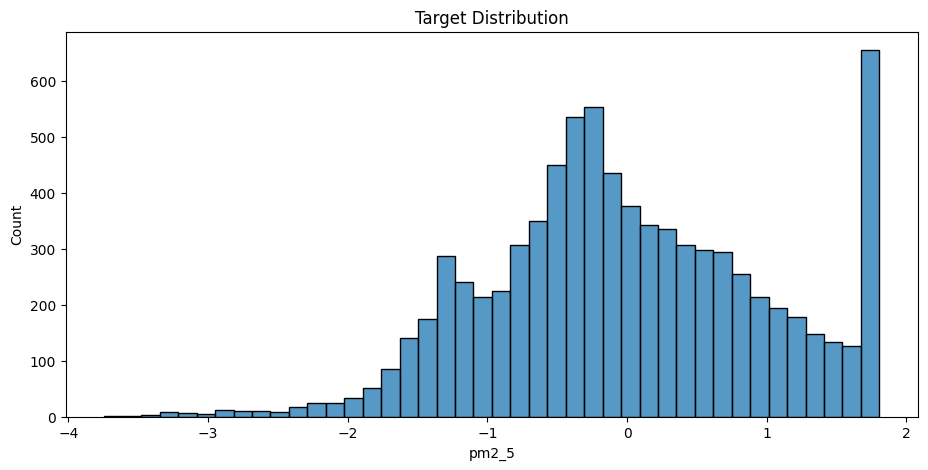

In [35]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(X_train_preprocessed_df.pm2_5)
plt.title('Target Distribution')
plt.show()

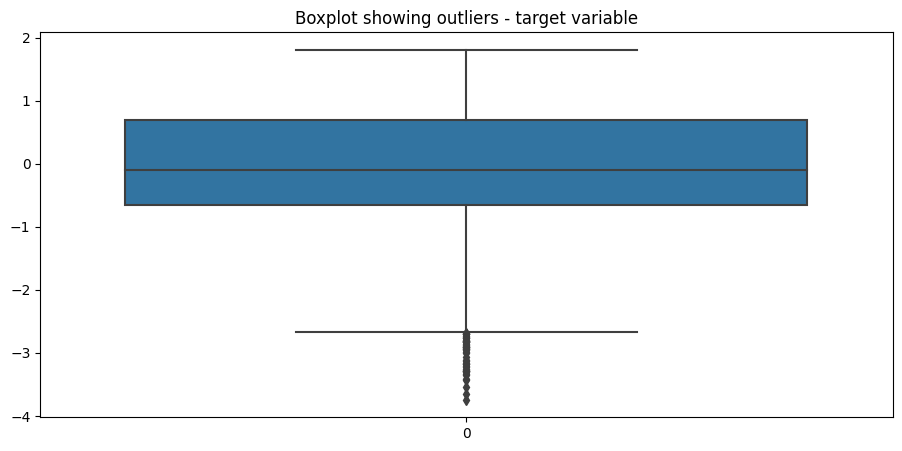

In [36]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(X_train_preprocessed_df.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

In [37]:
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=final_features)
X_test_preprocessed_df.head(2)

,formaldehyde_hcho_slant_column_number_density,ozone_o3_column_number_density,sulphurdioxide_solar_zenith_angle,site_latitude,carbonmonoxide_co_column_number_density,sulphurdioxide_so2_column_number_density,uvaerosolindex_absorbing_aerosol_index,nitrogendioxide_no2_column_number_density,cloud_solar_azimuth_angle,carbonmonoxide_cloud_height,ozone_sensor_zenith_angle,site_longitude,sulphurdioxide_so2_column_number_density_15km,formaldehyde_tropospheric_hcho_column_number_density,month,cloud_cloud_base_height,carbonmonoxide_solar_azimuth_angle,nitrogendioxide_tropopause_pressure,uvaerosollayerheight_aerosol_height,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_so2_slant_column_number_density,ozone_o3_column_number_density_amf,formaldehyde_solar_zenith_angle,ozone_o3_slant_column_number_density,cloud_cloud_base_pressure,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_absorbing_aerosol_index,cloud_cloud_top_pressure,cloud_cloud_fraction,nitrogendioxide_cloud_fraction,cloud_cloud_top_height,ozone_cloud_fraction,cloud_cloud_optical_depth,nitrogendioxide_tropospheric_no2_column_number_density,cloud_surface_albedo,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_solar_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_sensor_azimuth_angle,uvaerosollayerheight_aerosol_pressure,carbonmonoxide_h2o_column_number_density,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_aerosol_optical_depth,cloud_sensor_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density_amf,uvaerosollayerheight_sensor_zenith_angle,formaldehyde_sensor_zenith_angle,formaldehyde_cloud_fraction,formaldehyde_solar_azimuth_angle,sulphurdioxide_cloud_fraction,nitrogendioxide_no2_slant_column_number_density,uvaerosollayerheight_solar_zenith_angle,hour,cloud_solar_zenith_angle,pm2_5,carbonmonoxide_solar_zenith_angle
0,-0.19449,0.131711,-0.345702,2.310007,0.282734,0.178913,0.244025,-0.014280,0.046414,-1.638402,-0.759123,-3.244749,0.066803,-0.178232,0.841295,-1.458326,0.066018,0.059200,-0.001865,-0.738070,0.139370,-0.189523,-0.366878,-0.602222,1.686749,0.120546,0.121169,1.643305,-0.177031,-0.006309,-1.431244,-0.171459,0.161380,-0.011022,0.085301,-0.178260,0.057046,-0.237928,-0.297406,0.033806,0.205464,0.026985,0.145854,-0.752913,-0.207128,-0.143601,-0.751525,0.023277,0.061890,0.095295,-0.013890,-0.129541,2.601709,-0.418537,-0.99043,-0.394601
1,-1.35742,0.133157,-1.474360,2.310007,0.151356,0.927597,0.045780,1.382533,0.017002,-0.666011,-1.592249,-3.244749,-0.287843,-1.474157,0.841295,0.035937,0.042226,1.498053,1.284317,-2.150068,0.459708,-0.217701,-1.429507,-0.835012,-0.046049,-0.078641,0.979320,-0.011221,-0.308762,1.356534,-0.028643,-0.077452,-0.872965,1.380120,0.408545,-1.370669,0.100099,-0.477974,0.423765,-1.344691,0.071508,-0.124347,0.573385,-1.597146,-1.453450,0.787358,-2.126808,1.127363,0.148606,1.328462,1.417379,1.281870,2.601709,-1.016732,-0.99043,-0.872162


In [38]:
# Drop the fictitious 'pm2_5' column from X_train_preprocessed_df
X_test_preprocessed_df = X_test_preprocessed_df.drop('pm2_5', axis=1)

In [39]:
X_test_preprocessed_df.columns

Index(['formaldehyde_hcho_slant_column_number_density',
       'ozone_o3_column_number_density', 'sulphurdioxide_solar_zenith_angle',
       'site_latitude', 'carbonmonoxide_co_column_number_density',
       'sulphurdioxide_so2_column_number_density',
       'uvaerosolindex_absorbing_aerosol_index',
       'nitrogendioxide_no2_column_number_density',
       'cloud_solar_azimuth_angle', 'carbonmonoxide_cloud_height',
       'ozone_sensor_zenith_angle', 'site_longitude',
       'sulphurdioxide_so2_column_number_density_15km',
       'formaldehyde_tropospheric_hcho_column_number_density', 'month',
       'cloud_cloud_base_height', 'carbonmonoxide_solar_azimuth_angle',
       'nitrogendioxide_tropopause_pressure',
       'uvaerosollayerheight_aerosol_height',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_so2_slant_column_number_density',
       'ozone_o3_column_number_density_amf', 'formaldehyde_solar_zenith_angle',
       'ozone_o3_slant_column_number_density', 'clou

In [40]:
# Define the list of models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

In [41]:
# Define the parameter grids

param_grids = {
    'LinearRegression': {
        'fit_intercept': [True, False]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': [1e-4, 'scale'],
        'kernel': ['linear', 'rbf']
    }
}

In [42]:
# Define the target variable
target_variable = 'pm2_5'

# Split the preprocessed data into X_train_final and y_train_final
X_train_final = X_train_preprocessed_df.drop(target_variable, axis=1)
y_train_final = X_train_preprocessed_df[target_variable]

In [43]:
# Define a function to perform the grid search and tune the models
def tune_model(model_name, model, param_grid, X_train_fold, y_train_fold):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_fold, y_train_fold)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [44]:
# Evaluate each model using KFold cross-validation
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    rmses = []
    for train_index, val_index in kf.split(X_train_final, y_train_final):
        X_train_final_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
        y_train_final_fold, y_val_fold = y_train_final.iloc[train_index], y_train_final.iloc[val_index]

        # Tune the model using grid search
        tuned_model = tune_model(name, model, param_grids[name], X_train_final_fold, y_train_final_fold)
        
        tuned_model.fit(X_train_final_fold, y_train_final_fold)
        y_val_pred = tuned_model.predict(X_val_fold)
        
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        rmses.append(rmse)
    
    avg_rmse = np.mean(rmses)
    results[name] = avg_rmse
    print(f'{name} Mean RMSE: {avg_rmse}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for LinearRegression: {'fit_intercept': False}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for LinearRegression: {'fit_intercept': False}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for LinearRegression: {'fit_intercept': False}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for LinearRegression: {'fit_intercept': False}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for LinearRegression: {'fit_intercept': False}
LinearRegression Mean RMSE: 0.787442058760345
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for RandomForestRegressor: {'max_depth': 30, 'n_estimators': 200}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for RandomForestRegressor: {'max_depth': 30, 'n_estimators': 100}
Fitting 5 folds for each of 6 candidates, totalling 30 

In [45]:
# Find the best model based on RMSE
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f'Best model: {best_model_name} with Mean RMSE: {results[best_model_name]}')

Best model: RandomForestRegressor with Mean RMSE: 0.5510173560407804


In [46]:
# Prepare test data
X_test = X_test_preprocessed_df

In [47]:
# Train the best model on the entire training set and predict on the test set
best_model = tune_model(best_model_name, best_model, param_grids[best_model_name], X_train_final, y_train_final)
best_model.fit(X_train_final, y_train_final)
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for RandomForestRegressor: {'max_depth': 20, 'n_estimators': 200}


In [48]:
# Inverse transform the predictions to the original scale
y_test_predicted = transformer.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

In [49]:
# Create a DataFrame with 'id' and predicted 'pm2_5' values
result = pd.DataFrame({'id': test_data['id'], 'pm2_5': y_test_predicted})

# Save the predictions to a CSV file with 'id' and 'pm2_5' columns
result.to_csv('air_quality.csv', index=False)